<a href="https://colab.research.google.com/github/smkerr/COVID-fake-news-detection/blob/main/model/fine-tuned-model-no-tweet2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# import dependencies
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import pickle

[nltk_data] Downloading package stopwords to /Users/steve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/steve/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#mount drive to save modesl
from google.colab import drive
drive.mount('drive')

ModuleNotFoundError: No module named 'google'

In [2]:
# set seed
np.random.seed(42)

In [3]:
# load & clean data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Train.csv', header=0)
train_clean = train[train["tweet"].map(len) <= 280].drop_duplicates() # drop posts longer than 280 characters & drop duplicates
X_train, y_train = train_clean["tweet"], train_clean["label"]


val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Val.csv', header=0)
val_clean = val[val["tweet"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
X_val, y_val = val_clean["tweet"], val_clean["label"]

test = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Test.csv', header=0)
test_clean = test[test["tweet"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
X_test, y_test = test_clean["tweet"], test_clean["label"]

#new = pd.read_csv('new_data.csv', header=0)
#new_clean = new[new["statement"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
#X_new, y_new = new_clean["statement"], new_clean["label"]

# Pre-processing

In [4]:
# initialize lemmatizer 
lemmatizer = WordNetLemmatizer()

# create stop word list
stoplist = set(stopwords.words('english'))

# create CleanText() function
def CleanText(string):
    text = string.lower() # lowercase
    text = re.sub(r"http(\S)+",' ',text) # remove URLs   
    text = re.sub(r"www(\S)+",' ',text) # remove URLs
    text = re.sub(r"&",' and ',text) # replace & with ' and '
    text = text.replace('&amp',' ') # replace &amp with ' '
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # remove non-alphanumeric characters
    text = text.split() # splits into a list of words
    text = [w for w in text if not w in stoplist] # remove stop words
    text = [lemmatizer.lemmatize(w) for w in text] # lemmatization
    text = " ".join(text) # joins the list of words
    return text

# apply CleanText() function to all tweets 
X_train = X_train.map(lambda x: CleanText(x))
X_val = X_val.map(lambda x: CleanText(x))
X_test = X_test.map(lambda x: CleanText(x))
#X_new = X_new.map(lambda x: CleanText(x))

In [5]:
# initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# encode 'fake' as 0 and 'real' as 1 to make target variables machine-readable
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_test = label_encoder.fit_transform(y_test)
#y_new = label_encoder.fit_transform(y_new)

# Model Training

## #1 SVM

In [6]:
# create SVM object
svm_clf = SVC(kernel='linear',probability=True, C=10, class_weight='balanced')

# create pipeline
svm_pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', svm_clf) # classifier
])

# train model
fit = svm_pipeline.fit(X_train,y_train)

# make predictions
svm_pred = svm_pipeline.predict(X_val)

#make pred on test
svm_pred_test = svm_pipeline.predict(X_test)

In [7]:
#make pred on new data
#svm_pred_new = svm_pipeline.predict(X_new)

In [8]:
#save SVM model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_svm_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(svm_pipeline, file)

## #2 Logistic Regression

In [9]:
# create logistic regression object
lr_clf = LogisticRegression(max_iter=1000,penalty='none',solver='saga')

# create pipeline
lr_pipeline = Pipeline([
        ('count', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', lr_clf) # classifier
])

# train model
fit = lr_pipeline.fit(X_train,y_train)

# make predictions
lr_pred = lr_pipeline.predict(X_val) 

#make pred on test
lr_pred_test = lr_pipeline.predict(X_test) 

/Users/steve/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [10]:
#make pred on new
#lr_pred_new = lr_pipeline.predict(X_new) 

In [11]:
#save lr model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_lr_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(lr_pipeline, file)

## #3 Extreme Gradient Boost

In [12]:
# create XGBoost object 
xgb_clf = XGBClassifier(max_depth=3, min_child_weight=3, eta = 0.15, n_estimators = 550, subsample=0.85)

# create pipeline
xgb_pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', xgb_clf) # classifier
])

# train model 
fit = xgb_pipeline.fit(X_train,y_train)

# make predictions
xgb_pred = xgb_pipeline.predict(X_val)

#make pred on test
xgb_pred_test = xgb_pipeline.predict(X_test)


In [13]:
#make pred on new data
#xgb_pred_new = xgb_pipeline.predict(X_new)


In [14]:
#save xgb model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_xgb_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(xgb_pipeline, file)

## #4 Adaptive Boost

In [15]:
# create AdaBoost object
ada_clf = AdaBoostClassifier(n_estimators=500, learning_rate = 1.0)

# create pipeline
ada_pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', ada_clf) # classifier
])

# train model
fit = ada_pipeline.fit(X_train,y_train)

# make predictions
ada_pred = ada_pipeline.predict(X_val)

#make pred on test
ada_pred_test = ada_pipeline.predict(X_test)


In [16]:
#make pred on new data
#ada_pred_new = ada_pipeline.predict(X_new)

In [17]:
#save ada model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_ada_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(ada_clf, file)

## #5 Voting Classifier

In [18]:
named_estimators = [ # for each of the individual models
    ("SVM", svm_pipeline),
    ("Logistic Regression", lr_pipeline),
    ("XGBoost", xgb_pipeline),
    ("AdaBoost", ada_pipeline)
]

In [19]:
# voting classifier
voting_clf = VotingClassifier(named_estimators, voting = "soft") #soft voting (predicts the class label based on the argmax of the sums of the predicted probabilities)

# train model
voting_clf.fit(X_train,y_train)

# make prediction
voting_pred = voting_clf.predict(X_val)

#make pred test
voting_pred_test = voting_clf.predict(X_test)


/Users/steve/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [20]:
#make pred new data
#voting_pred_new = voting_clf.predict(X_new)

In [21]:
#save ensemble model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_voting_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(voting_pipeline, file)

# Evaluation

In [22]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [23]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

## #1 SVM

[[891  57]
 [ 54 871]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       948
           1       0.94      0.94      0.94       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9407367859049653
Precison :  0.9407395860179927
Recall :  0.9407367859049653
F1 :  0.9407357722026964


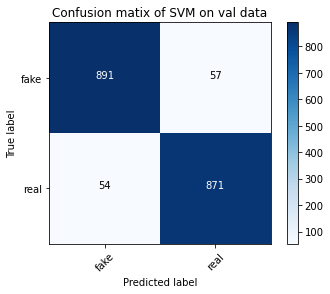

In [24]:
# display results
print_metrics(svm_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,svm_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

[[883  61]
 [ 61 843]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       944
           1       0.93      0.93      0.93       904

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy :  0.933982683982684
Precison :  0.933982683982684
Recall :  0.933982683982684
F1 :  0.933982683982684


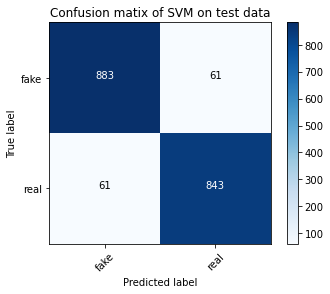

In [25]:
# display results test data
print_metrics(svm_pred_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test,svm_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on test data')

In [26]:
# display results new data
#print_metrics(svm_pred_new, y_new)
#plot_confusion_matrix(confusion_matrix(y_new,svm_pred_new),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of SVM on new data')

NameError: name 'svm_pred_new' is not defined

## #2 Logisitic Regression

[[897  51]
 [ 62 863]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       948
           1       0.94      0.93      0.94       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9396689802455953
Precison :  0.9397466765325139
Recall :  0.9396689802455953
F1 :  0.9396754142276613


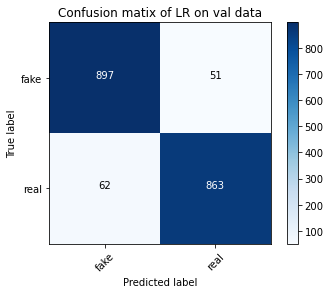

In [27]:
# display results
print_metrics(lr_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,lr_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

[[881  63]
 [ 72 832]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       944
           1       0.93      0.92      0.92       904

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy :  0.926948051948052
Precison :  0.9270109191374846
Recall :  0.926948051948052
F1 :  0.9269574919459335


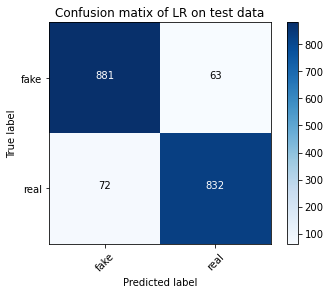

In [28]:
# display results test data
print_metrics(lr_pred_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test,lr_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on test data')

In [ ]:
# display results new data
#print_metrics(lr_pred_new, y_new)
#plot_confusion_matrix(confusion_matrix(y_new,lr_pred_new),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of LR on new data')

## #3 Extreme Gradient Boost

[[877  71]
 [ 97 828]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       948
           1       0.92      0.90      0.91       925

    accuracy                           0.91      1873
   macro avg       0.91      0.91      0.91      1873
weighted avg       0.91      0.91      0.91      1873

Accuracy :  0.9103043246129204
Precison :  0.910720357235729
Recall :  0.9103043246129204
F1 :  0.9103369204932747


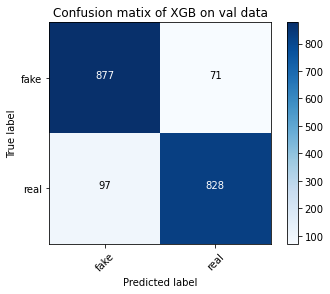

In [29]:
# display results
print_metrics(xgb_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val, xgb_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of XGB on val data')

[[874  70]
 [118 786]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       944
           1       0.92      0.87      0.89       904

    accuracy                           0.90      1848
   macro avg       0.90      0.90      0.90      1848
weighted avg       0.90      0.90      0.90      1848

Accuracy :  0.8982683982683982
Precison :  0.8997327731016047
Recall :  0.8982683982683982
F1 :  0.8983945118242639


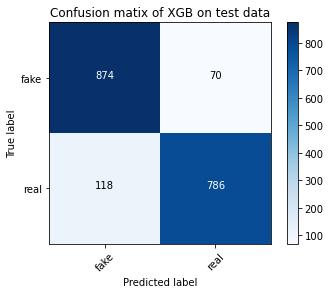

In [30]:
# display results on test data
print_metrics(xgb_pred_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test, xgb_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of XGB on test data')

In [ ]:
# display results new data
#print_metrics(xgb_pred_new, y_new)
#plot_confusion_matrix(confusion_matrix(y_new, xgb_pred_new),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of XGB on new data')

## #4 Adaptive Boost

[[833 115]
 [110 815]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       948
           1       0.88      0.88      0.88       925

    accuracy                           0.88      1873
   macro avg       0.88      0.88      0.88      1873
weighted avg       0.88      0.88      0.88      1873

Accuracy :  0.8798718633208756
Precison :  0.8798782410516783
Recall :  0.8798718633208756
F1 :  0.8798687811848102


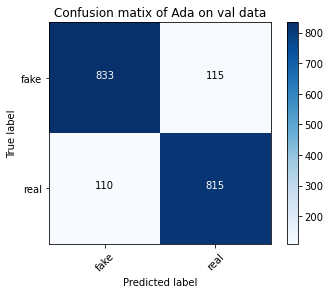

In [31]:
# display results
print_metrics(ada_pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,ada_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on val data')

[[826 118]
 [101 803]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       944
           1       0.87      0.89      0.88       904

    accuracy                           0.88      1848
   macro avg       0.88      0.88      0.88      1848
weighted avg       0.88      0.88      0.88      1848

Accuracy :  0.8814935064935064
Precison :  0.88161561889438
Recall :  0.8814935064935064
F1 :  0.8814799364184719


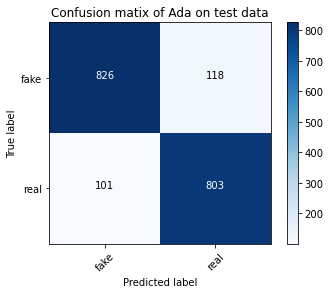

In [32]:
# display results on test data
print_metrics(ada_pred_test,y_test)
plot_confusion_matrix(confusion_matrix(y_test,ada_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on test data')

In [ ]:
# display results new data
#print_metrics(ada_pred_new,y_new)
#plot_confusion_matrix(confusion_matrix(y_new,ada_pred_new),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of Ada on new data')

## #5 Voting Classifier

[[893  55]
 [ 64 861]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       948
           1       0.94      0.93      0.94       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9364655632674853
Precison :  0.9365192476262513
Recall :  0.9364655632674853
F1 :  0.9364707806527016


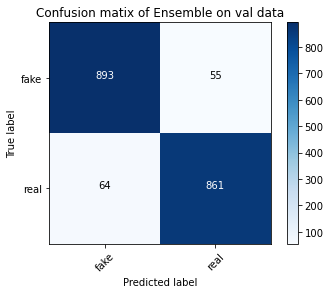

In [33]:
# display results
print_metrics(voting_pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,voting_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on val data')

[[881  63]
 [ 72 832]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       944
           1       0.93      0.92      0.92       904

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy :  0.926948051948052
Precison :  0.9270109191374846
Recall :  0.926948051948052
F1 :  0.9269574919459335


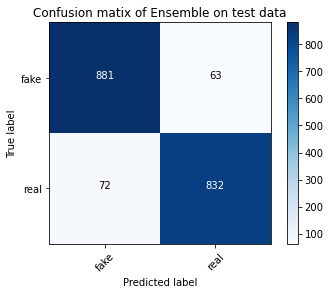

In [34]:
# display results
print_metrics(voting_pred_test,y_test)
plot_confusion_matrix(confusion_matrix(y_test,voting_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on test data')

In [ ]:
# display results new data
#print_metrics(voting_pred_new,y_new)
#plot_confusion_matrix(confusion_matrix(y_new,voting_pred_new),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of Ensemble on new data')

# Error Analysis

In [36]:
len(y_val)

1873

In [37]:
len(svm_pred)

1873

In [38]:
len(val)

2140

In [40]:
# error analysis, to compare the false classifications of the different models
false_pred_svm = X_val[(y_val != svm_pred)]
false_pred_xgb = X_val[(y_val != xgb_pred)]
false_pred_lr = X_val[(y_val != lr_pred)]
false_pred_ada = X_val[(y_val != ada_pred)]
false_pred_ensemble = X_val[(y_val != voting_pred)]

# compile common mistakes
common_mistakes_df = false_pred_svm = false_pred_gb = false_pred_lr = false_pred_xg = false_pred_ada = false_pred_ensemble

# inspect df
print(f"{len(common_mistakes_df)} tweets have consistently been misclassified by all of our models.\nThat's about {100*round(len(common_mistakes_df)/len(y_val),1)}% of tweets.")
common_mistakes_df.head()

119 tweets have consistently been misclassified by all of our models.
That's about 10.0% of tweets.


1     11 13 people diamond princess cruise ship inti...
10    still fly friendly sky without fear covid airl...
13    tomorrow april 6 pas 10000 coronavirus death p...
17    gov andrew cuomo simply saying share 20 percen...
55    india 3 covid19vaccine trial underway dcgi per...
Name: tweet, dtype: object

In [ ]:
# save 'common_mistakese' as .csv
common_mistakes_df = pd.merge(false_pred_svm, false_pred_ada, on=['tweet'], how='inner')
print(common_mistakes_df)

In [ ]:
# mount drive to save data
from google.colab import drive
drive.mount('drive')

In [ ]:
# save to Google Drive
common_mistakes.to_csv('/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/error_analysis/common_mistakes.csv', encoding='utf-8')